In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
opj = os.path.join
CODE_DIR = os.path.abspath('../..')
sys.path.append(opj(CODE_DIR, 'EPypes'))
sys.path.append(opj(CODE_DIR, 'RPALib'))

In [2]:
import math
import multiprocessing as mp
from matplotlib import pyplot as plt
import networkx as nx
from glob import glob
import nxpd

nxpd.nxpdParams['show'] = 'ipynb'
plt.gray()

In [3]:
from epypes import pipeline
from epypes import compgraph

from rpa import cbcalib
from rpa.io import open_image

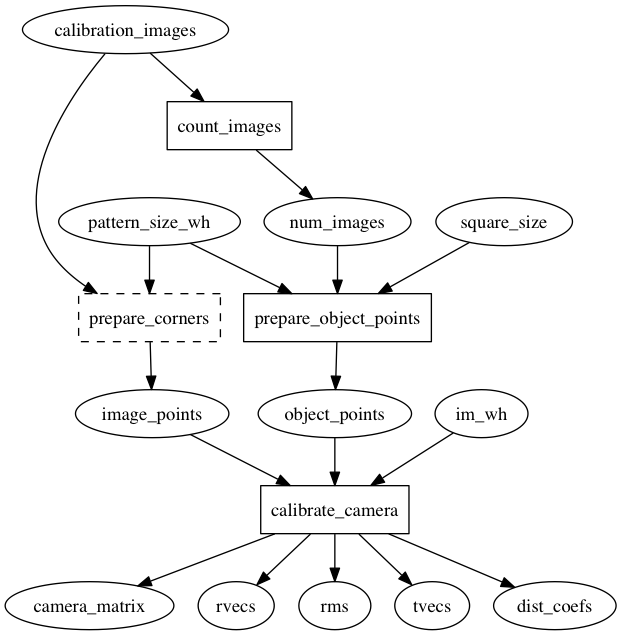

In [4]:
cg_calib = cbcalib.CGCalibrateCamera()

nxpd.draw(cg_calib.to_networkx())

In [5]:
cg_corners = cbcalib.CGFindCorners()

def prepare_corners(images, psize):
    runner = compgraph.CompGraphRunner(cg_corners, frozen_tokens={'pattern_size_wh': psize})
    
    res = []
    for im in images:
        
        runner.run(image=im)

        if runner.token_value('success') is True:
            res.append(runner.token_value('corners_np'))
        
    return res

In [6]:
imfiles = glob(opj(CODE_DIR, 'DATA/IMG/calib/opencv_left/*.jpg'))
images = [open_image(f) for f in imfiles]
psize = (9, 6)
sq_size = 10

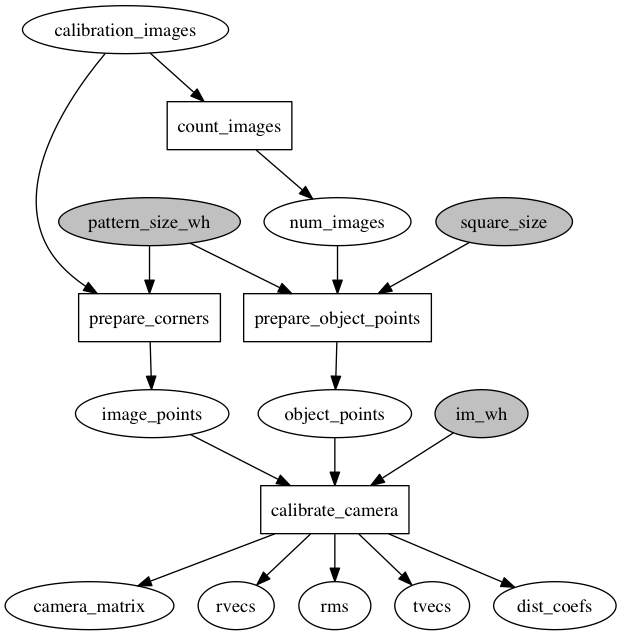

In [7]:
cg_calib.swap_function('prepare_corners', prepare_corners)

runner = compgraph.CompGraphRunner(cg_calib, frozen_tokens={
    'im_wh': cbcalib.get_im_wh(images[0]),
    'pattern_size_wh': psize,
    'square_size': sq_size
    
})

nxpd.draw(runner.token_manager.to_networkx())

In [8]:
runner.run(calibration_images=images)

In [9]:
runner.token_value('camera_matrix')

array([[ 532.79536563,    0.        ,  342.4582516 ],
       [   0.        ,  532.91928339,  233.90060514],
       [   0.        ,    0.        ,    1.        ]])

In [10]:
runner.token_value('dist_coefs')

array([[ -2.81086258e-01,   2.72581023e-02,   1.21665908e-03,
         -1.34204277e-04,   1.58514021e-01]])

In [16]:
print('Number of calibration images opened: ', len(runner.token_value('calibration_images')))
print('Number of images with good corners', len(runner.token_value('image_points')))

Number of calibration images opened:  13
Number of images with good corners 13


In [11]:
#%timeit runner.run(calibration_images=images)